# **Mockup of the FIDJI (FIDucial aDJustable ProcessIng) processing**

## Introduction

This mockup is dedicated to describe the ***processing*** developed to ***produce FRM*** on super site. 
This code has been applied to the ***Marmande Super-Site over the Garonne River*** which represents the ***maximum condition we consider***:

    - No in-situ station at less than 1 km from a Sentinel-3 ground track
    - Strong river slope (Garonne River)
    - Dynamic river evolution
    - Mid-size width river

*Disclaimer:* This model is not yet generic, adjustments need to be made before it is released to users.

### <ins>**Requirements:**</ins>

For each site, FIDJI needs:

- A centerline / curvilinear abscissa
- If the FRM in-situ station is located at more than 1 km from the Sentinel-3 ground track and/or if the river has a strong slope, one or more river profiles are needed (example: river profiles from drone campaigns)
- +/-5 days of in-situ data around the Sentinel-3 pass from 2 in-situ stations to compute propagation time if the FRM in-situ station is located at more than 1 km from the ground track
- At least, 1 FRM in-situ station (which could be one of the 2 in-situ stations present in the area, as mentioned above)

## The FIDJI processing

### First load python modules

In [2]:
# -*- coding: utf-8 -*-

#######################################################
#   mockup for computing FRM in super Cal/Val sites   #
#######################################################

# 04/11/2022.... JC.Poisson Creation

# generic libs
import datetime as dt
import numpy as np
import pandas as pd
import geopandas as gpd
import netCDF4 as nc4
import matplotlib.pyplot as plt
import contextily as cx
import yaml
import scipy as scp

# specific libs
from frmlib import frmtools
import s3lib.s3data as s3
from vigicrueslib import vigidata
from vtxlib import vtxdata

### Load the centerline

Here, this centerline comes from the French river databse called "Topage"

Text(0.5, 1.0, 'Visualization of the centerline in Marmande')

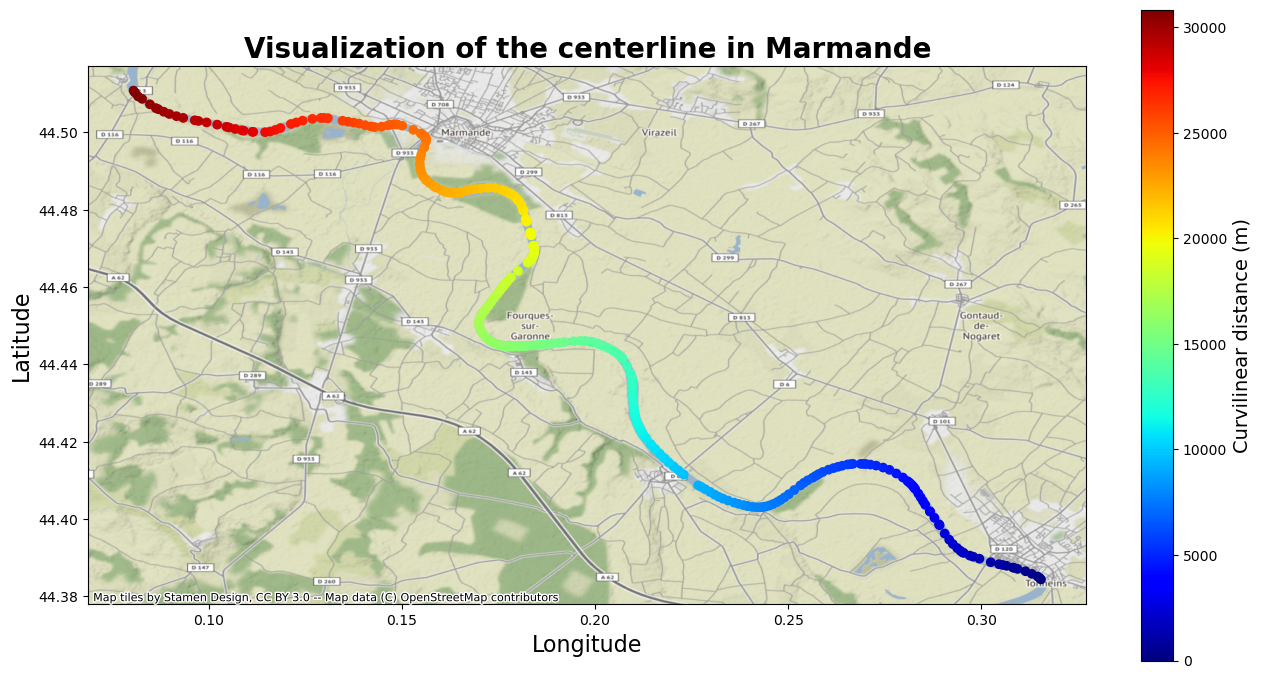

In [3]:
# define file path
kml_file = "garonne.kml"

# create object
centerline = frmtools.CurvAbsc()

# load object with kml file
centerline.load_kml(kml_file)

# compute curvilinear abscissa between 2 positions
centerline.compute_curvilinear_abscissa(0.315642, 44.384417, 0.080448, 44.510941)

# visualize
fig, ax = plt.subplots(figsize=(14,12))
plt.scatter(*centerline.coordinates, c=centerline.distances, cmap='jet')
cx.add_basemap(ax, crs="EPSG:4326")
cbar = plt.colorbar(ax=ax, fraction=0.03)
cbar.set_label("Curvilinear distance (m)", fontsize=14)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title("Visualization of the centerline in Marmande", fontsize=20, fontweight='bold')

### Load the river profiles *(here from drone campaign)*

Here we will correct from the water level evolution that occured during the campaign just to explain how we correct the drone profile from it.
**Of course, this correction will be direclty applied to the drone profile that will be provided on the FRM data hub.**

#### *Load the first drone profile*

In [4]:

# define file path
drone_nc_file = "marmande_02_2022.nc"

# load drone data
drone_data_1 = frmtools.DRONE_DATA()
drone_data_1.load_drone_file(drone_nc_file)


0

Projection of the drone profile on the centerline 

In [5]:
# project on curvilinear abscissa
coord_proj, dist_proj = centerline.proj_to_curvilinear_abscissa(drone_data_1.df['lon'], drone_data_1.df['lat'])
drone_data_1.project_on_centerline(coord_proj[0,:], coord_proj[1,:], dist_proj)


0

Collect in-situ measurements located at each side of the drone profile in order to compute the propagtion time to correct from the water level evolution during the drone campaign

c:\Users\Jean-ChristophePoiss\OneDrive - vorteX.io\St3TART\mockup\vigicrueslib\vigidata.py:73: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_data.v_m_positive = df_data.v_m + np.abs(df_data.v_m.min())
c:\Users\Jean-ChristophePoiss\OneDrive - vorteX.io\St3TART\mockup\vigicrueslib\vigidata.py:73: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_data.v_m_positive = df_data.v_m + np.abs(df_data.v_m.min())


Text(0.5, 1.0, 'Verify the computed time shift of: 11400.0 seconds')

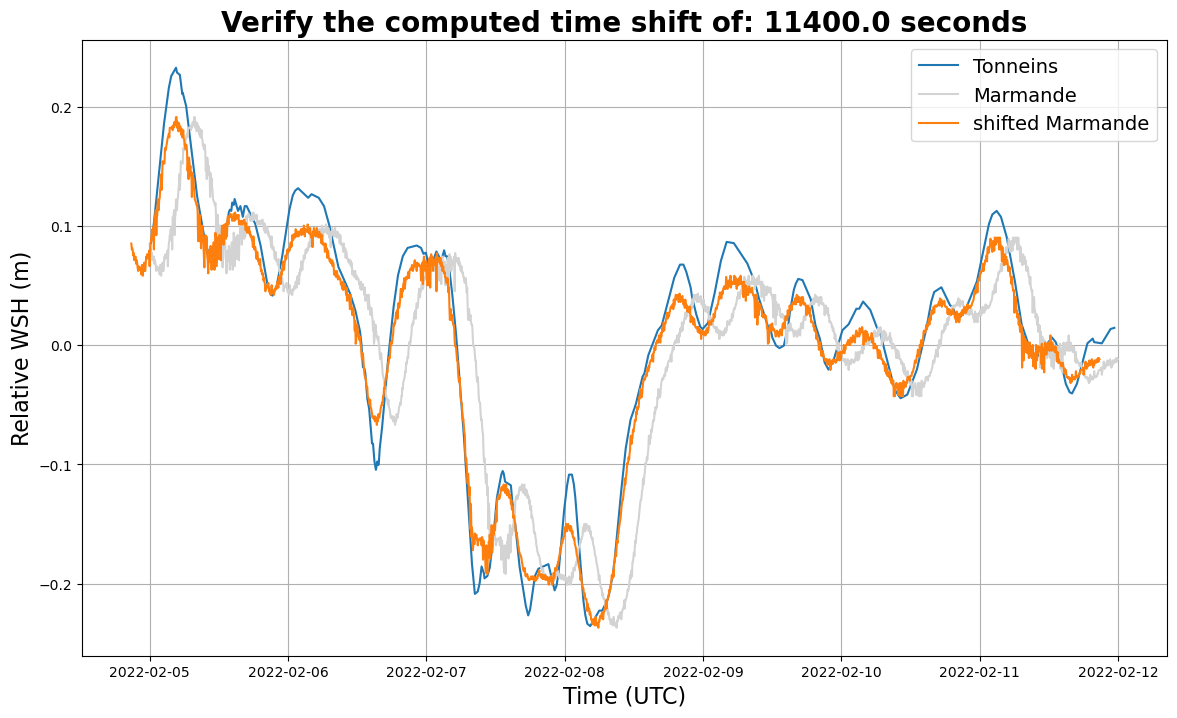

In [6]:
# look for Vigicrues data up to +/-2.5 days before and after the drone flight
add_time = dt.timedelta(days=2.5)
vigi_tonneins = vigidata.VIGICRUES_DATA()
vigi_tonneins.set_params("O900001002", pd.Timestamp.to_pydatetime(drone_data_1.df['time'].min()) - add_time, pd.Timestamp.to_pydatetime(drone_data_1.df['time'].max()) + add_time)
vigi_tonneins.request_data()

vigi_marmande = vigidata.VIGICRUES_DATA()
vigi_marmande.set_params("O909001001", pd.Timestamp.to_pydatetime(drone_data_1.df['time'].min()) - add_time, pd.Timestamp.to_pydatetime(drone_data_1.df['time'].max()) + add_time)
vigi_marmande.request_data()

# estimate time_shift between the 2 stations
time_shift_sec_1 = frmtools.estimate_time_shift(vigi_tonneins.df['time_sec'], vigi_tonneins.df['wsh'], vigi_marmande.df['time_sec'], vigi_marmande.df['wsh'])

# plot
fig, ax = plt.subplots(figsize=(14,8))
plt.plot(vigi_tonneins.df['time'], vigi_tonneins.df['wsh'] - vigi_tonneins.df['wsh'].mean(), label='Tonneins')
plt.plot(vigi_marmande.df['time'], vigi_marmande.df['wsh'] - vigi_marmande.df['wsh'].mean(), color='lightgrey', label='Marmande')
plt.plot(vigi_marmande.df['time']-dt.timedelta(seconds=time_shift_sec_1), vigi_marmande.df['wsh'] - vigi_marmande.df['wsh'].mean(), label='shifted Marmande')
plt.grid()
plt.legend(loc='best', fontsize=14)
plt.xlabel('Time (UTC)', fontsize=16)
plt.ylabel('Relative WSH (m)', fontsize=16)
plt.title("Verify the computed time shift of: "+str(time_shift_sec_1)+" seconds", fontsize=20, fontweight='bold')

Compute the distance between the two in-situ stations, then the average propagation speed and finally correct the drone profile from the river evolution during the campaign

22972.86726834382


Text(0.5, 1.0, 'Verify the water level evolution correction on drone data')

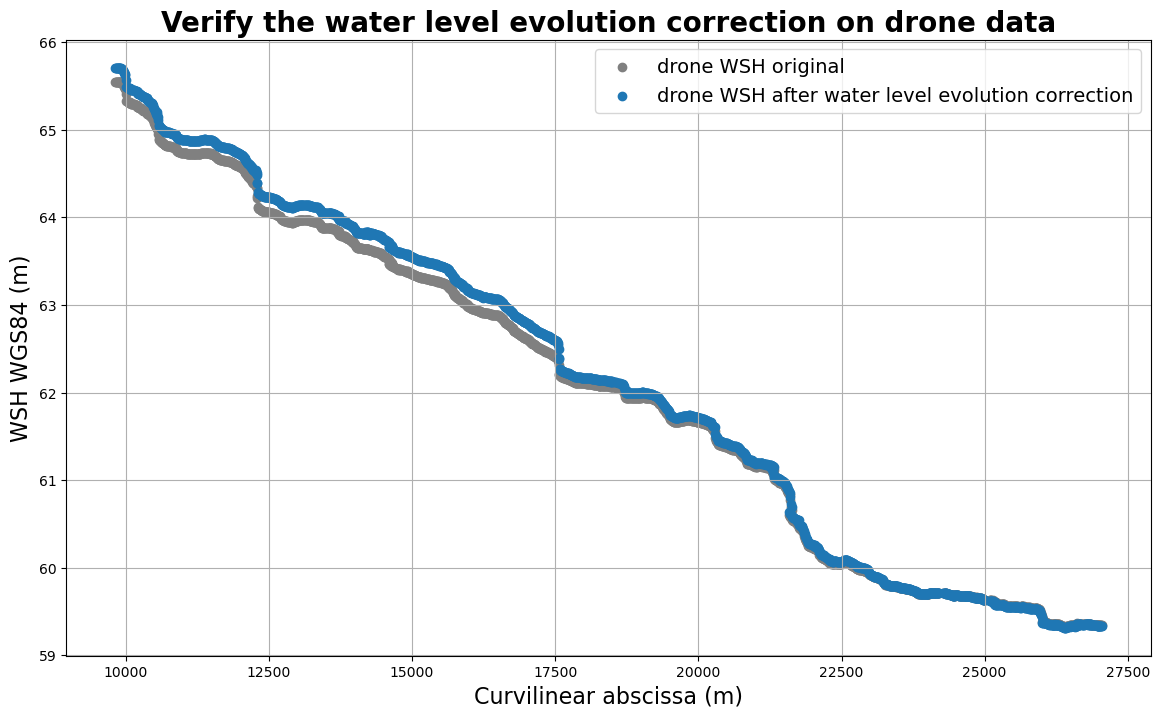

In [7]:
# proj vigicrues stations on centerline
vigi_tonneins_coords, vigi_tonneins_absc = centerline.proj_to_curvilinear_abscissa(np.array([0.30114688627728498]), np.array([44.388928198490099]))
vigi_marmande_coords, vigi_marmande_absc = centerline.proj_to_curvilinear_abscissa(np.array([0.15621536185923801]), np.array([44.499677838603702]))
d_vigi = (vigi_marmande_absc - vigi_tonneins_absc)[0]
print(d_vigi)

# compute average speed for the drone flight
avg_speed_1 = d_vigi / time_shift_sec_1

# correct the drone profile from the water evolution
drone_data_1.correct_from_water_evolution(avg_speed_1, vigi_marmande.df['time_sec'].values, vigi_marmande.df['wsh'], vigi_marmande_absc)

# plot
fig, ax = plt.subplots(figsize=(14,8))
plt.scatter(drone_data_1.df['absc_curv'], drone_data_1.df['wsh_wgs84'], color='grey', label='drone WSH original')
plt.scatter(drone_data_1.df['absc_curv'], drone_data_1.df['wsh_evo_corrected'], label='drone WSH after water level evolution correction')
plt.grid()
plt.legend(loc='best', fontsize=14)
plt.xlabel('Curvilinear abscissa (m)', fontsize=16)
plt.ylabel('WSH WGS84 (m)', fontsize=16)
plt.title("Verify the water level evolution correction on drone data", fontsize=20, fontweight='bold')

#### *Load the second drone profile*

In [8]:
# define file path
drone_nc_file = "marmande_06_2022.nc"

# load drone data
drone_data_2 = frmtools.DRONE_DATA()
drone_data_2.load_drone_file(drone_nc_file)

0

Projection of the second drone profile on the centerline 

In [9]:
# project on curvilinear abscissa
coord_proj, dist_proj = centerline.proj_to_curvilinear_abscissa(drone_data_2.df['lon'], drone_data_2.df['lat'])
drone_data_2.project_on_centerline(coord_proj[0,:], coord_proj[1,:], dist_proj)

0

Collect in-situ measurements located at each side of the drone profile in order to compute the propagtion time to correct from the water level evolution during the drone campaign

c:\Users\Jean-ChristophePoiss\OneDrive - vorteX.io\St3TART\mockup\vigicrueslib\vigidata.py:73: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_data.v_m_positive = df_data.v_m + np.abs(df_data.v_m.min())
c:\Users\Jean-ChristophePoiss\OneDrive - vorteX.io\St3TART\mockup\vigicrueslib\vigidata.py:73: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_data.v_m_positive = df_data.v_m + np.abs(df_data.v_m.min())


Text(0.5, 1.0, 'Verify the computed time shift of: 12600.0 seconds')

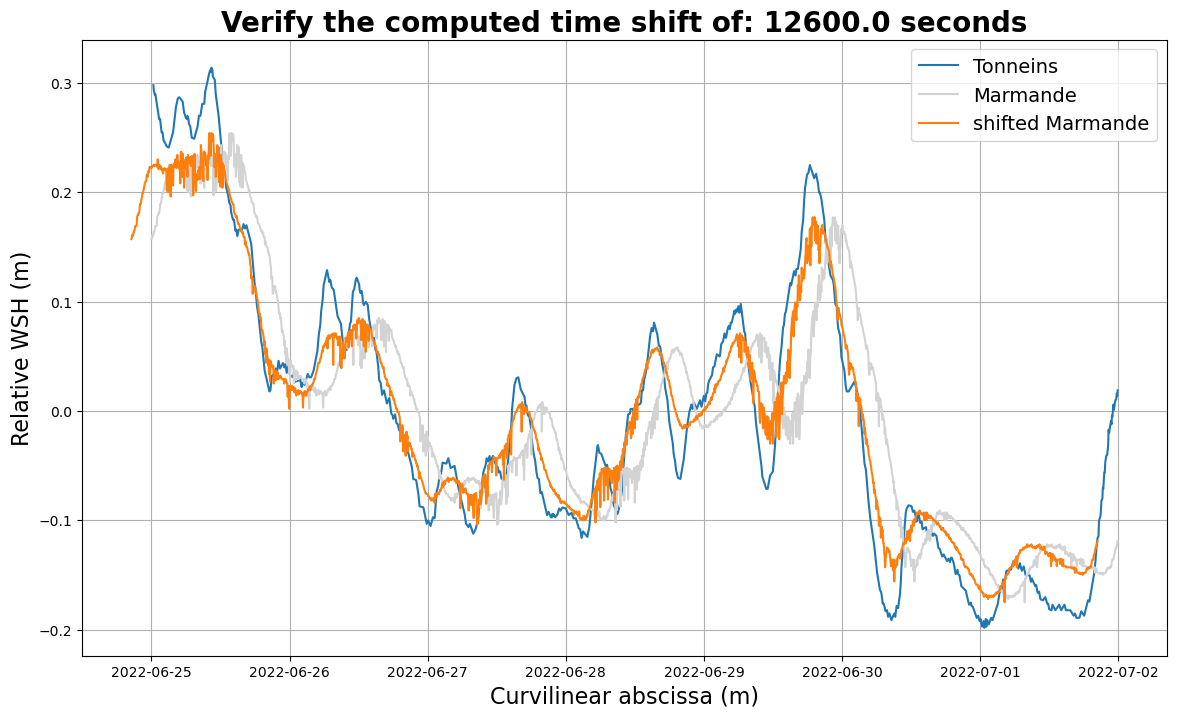

In [10]:
# look for Vigicrues data up to +/-2.5 days before and after the drone flight
add_time = dt.timedelta(days=2.5)
vigi_tonneins = vigidata.VIGICRUES_DATA()
vigi_tonneins.set_params("O900001002", pd.Timestamp.to_pydatetime(drone_data_2.df['time'].min()) - add_time, pd.Timestamp.to_pydatetime(drone_data_2.df['time'].max()) + add_time)
vigi_tonneins.request_data()

vigi_marmande = vigidata.VIGICRUES_DATA()
vigi_marmande.set_params("O909001001", pd.Timestamp.to_pydatetime(drone_data_2.df['time'].min()) - add_time, pd.Timestamp.to_pydatetime(drone_data_2.df['time'].max()) + add_time)
vigi_marmande.request_data()

# estimate time_shift between the 2 stations
time_shift_sec_2 = frmtools.estimate_time_shift(vigi_tonneins.df['time_sec'], vigi_tonneins.df['wsh'], vigi_marmande.df['time_sec'], vigi_marmande.df['wsh'])

# plot
fig, ax = plt.subplots(figsize=(14,8))
plt.plot(vigi_tonneins.df['time'], vigi_tonneins.df['wsh'] - vigi_tonneins.df['wsh'].mean(), label='Tonneins')
plt.plot(vigi_marmande.df['time'], vigi_marmande.df['wsh'] - vigi_marmande.df['wsh'].mean(), color='lightgrey', label='Marmande')
plt.plot(vigi_marmande.df['time']-dt.timedelta(seconds=time_shift_sec_2), vigi_marmande.df['wsh'] - vigi_marmande.df['wsh'].mean(), label='shifted Marmande')
plt.grid()
plt.legend(loc='best', fontsize=14)
plt.xlabel('Curvilinear abscissa (m)', fontsize=16)
plt.ylabel('Relative WSH (m)', fontsize=16)
plt.title("Verify the computed time shift of: "+str(time_shift_sec_2)+" seconds", fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'Verify the water level evolution correction on drone data')

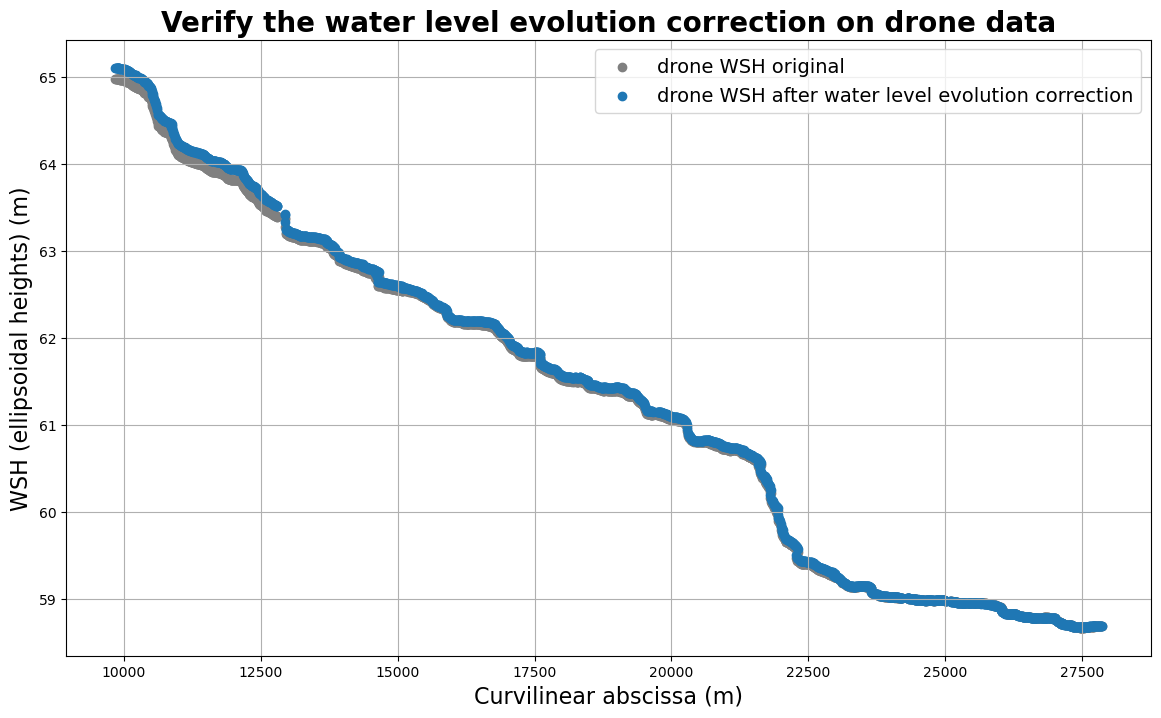

In [11]:
# compute average speed for the drone flight
avg_speed_2 = d_vigi / time_shift_sec_2

# correct the drone profile from the water evolution
drone_data_2.correct_from_water_evolution(avg_speed_2, vigi_marmande.df['time_sec'].values, vigi_marmande.df['wsh'], vigi_marmande_absc)

# plot
fig, ax = plt.subplots(figsize=(14,8))
plt.scatter(drone_data_2.df['absc_curv'], drone_data_2.df['wsh_wgs84'], color='grey', label='drone WSH original')
plt.scatter(drone_data_2.df['absc_curv'], drone_data_2.df['wsh_evo_corrected'], label='drone WSH after water level evolution correction')
plt.grid()
plt.legend(loc='best', fontsize=14)
plt.xlabel('Curvilinear abscissa (m)', fontsize=16)
plt.ylabel('WSH (ellipsoidal heights) (m)', fontsize=16)
plt.title("Verify the water level evolution correction on drone data", fontsize=20, fontweight='bold')

### Load Sentinel-3A data for the first Virtual Station

In [9]:
# choose cycle to process
cycle = 86

# load orf and choose a cycle
s3a_orf = s3.S3_ORF()
s3a_orf.load_orf("C:\\Users\\Jean-ChristophePoiss\\OneDrive - vorteX.io\\St3TART\\tools\\s3lib\\S3A_ORF_AXXCNE20221103_075200_20160302_154759_20221118_081841")
l_dates = s3a_orf.get_cycle_dates(cycle)

# create object
s3data = s3.S3_HYDRO_DATA()

# set api login/passwd and connect
with open('scihub_credentials.yaml') as f:
    credentials = yaml.load(f, Loader=yaml.loader.SafeLoader)
s3data.set_api_user(credentials['login'], credentials['passwd'])
s3data.api_connect()

# download S3 data on the first VS
lon_target = 0.161646
lat_target = 44.484419
ron = 222
s3data.set_target(lon_target, lat_target)
s3data.download_s3_l2_products(l_dates[0], l_dates[1], s3sat='S3A', relativeorbitnumber=ron)
df = s3data.load_product_into_dataframe()
s3data.compute_wsh(df)

# visualize
fig, ax = plt.subplots(figsize=(14,8))
plt.plot(*centerline.coordinates, color='k')
plt.scatter(s3data.df['lon'], s3data.df['lat'], color='orangered')
cx.add_basemap(ax, crs="EPSG:4326")
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title("Visualization of the S3Data on cycle "+str(cycle)+" and R.O.N.: "+str(ron), fontsize=20, fontweight='bold')


# # remove download file
# s3data.remove_ncfile()
# s3data.remove_product()

NameError: name 's3' is not defined

Select the closest point from the river and project on the centerline

In [ ]:
# project on the centerline
d_s3a_meas = s3data.select_wsh()
s3a_coord_proj, s3a_absc_curv = centerline.proj_to_curvilinear_abscissa(np.array([d_s3a_meas['lon']]), np.array([d_s3a_meas['lat']]))


### Now compute the FRM value at the actual satellite location

First, load micro-station in-situ data of the 2 micro-station on both sides of the area on a period of +/- 2.5 days around the satellite pass.
The objective is to compute the propagation time. (maybe there is something to improve here, we may use an estimator)

Text(0.5, 1.0, 'Verify the computed time shift of: 7200.0 seconds')

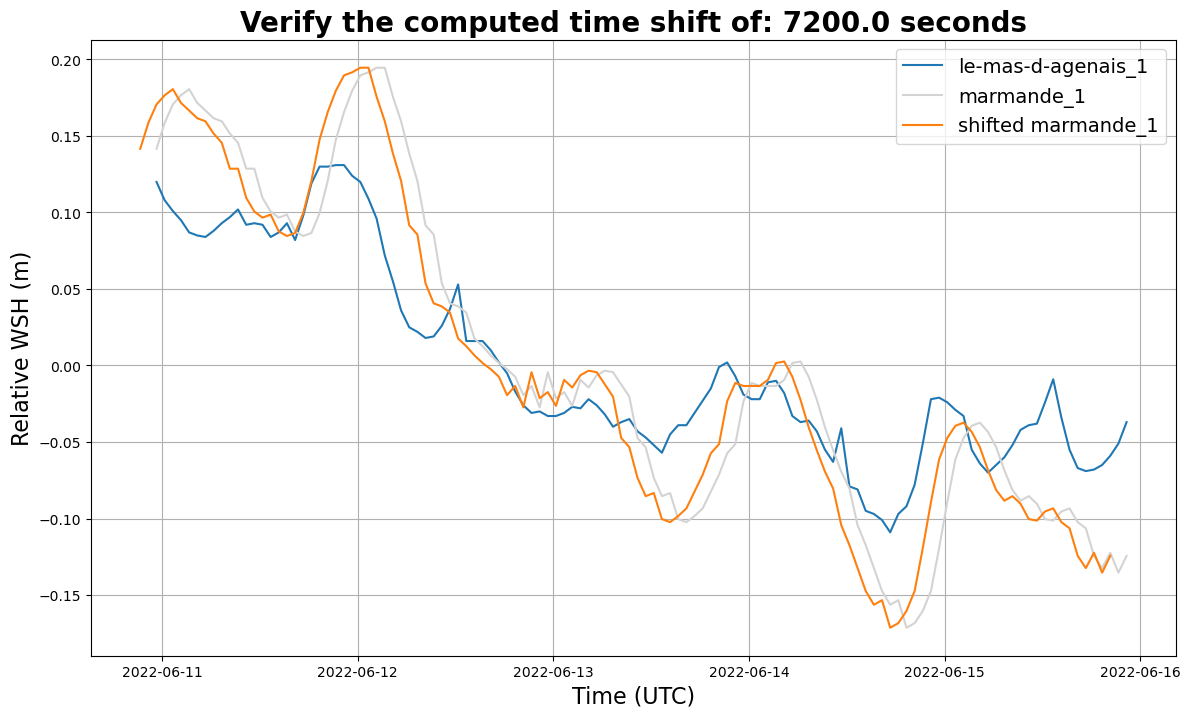

In [ ]:
# look for VorteX-io data up to +/-2.5 days before and after the S3 measurements
add_time = dt.timedelta(days=2.5)
vtx_masdagenais = vtxdata.VORTEXIO_DATA()
vtx_masdagenais.set_params("le-mas-d-agenais_1", d_s3a_meas['time'] - add_time, d_s3a_meas['time'] + add_time)
vtx_masdagenais.request_data()

vtx_marmande = vtxdata.VORTEXIO_DATA()
vtx_marmande.set_params("marmande_1", d_s3a_meas['time'] - add_time, d_s3a_meas['time'] + add_time)
vtx_marmande.request_data()

# estimate time_shift between the 2 stations
time_shift_sec_vtx = frmtools.estimate_time_shift(vtx_masdagenais.df['time_sec'], vtx_masdagenais.df['wsh'], vtx_marmande.df['time_sec'], vtx_marmande.df['wsh'])

# plot
fig, ax = plt.subplots(figsize=(14,8))
plt.plot(vtx_masdagenais.df['time'], vtx_masdagenais.df['wsh'] - vtx_masdagenais.df['wsh'].mean(), label='le-mas-d-agenais_1')
plt.plot(vtx_marmande.df['time'], vtx_marmande.df['wsh'] - vtx_marmande.df['wsh'].mean(), color='lightgrey', label='marmande_1')
plt.plot(vtx_marmande.df['time']-dt.timedelta(seconds=time_shift_sec_vtx), vtx_marmande.df['wsh'] - vtx_marmande.df['wsh'].mean(), label='shifted marmande_1')
plt.grid()
plt.legend(loc='best', fontsize=14)
plt.xlabel('Time (UTC)', fontsize=16)
plt.ylabel('Relative WSH (m)', fontsize=16)
plt.title("Verify the computed time shift of: "+str(time_shift_sec_vtx)+" seconds", fontsize=20, fontweight='bold')

Project station location on the centerline, compute the distance between the 2 micro-stations, compute the propagation time, speed. Finally remove the local geoid correction from the micro-station measurements (we are working here in ellipsoidal heights).

In [ ]:
# proj vorteX-io stations on centerline
vtx_masdagenais_coords, vtx_masdagenais_absc = centerline.proj_to_curvilinear_abscissa(np.array([0.222118]), np.array([44.412006]))
vtx_marmande_coords, vtx_marmande_absc = centerline.proj_to_curvilinear_abscissa(np.array([0.147242]), np.array([44.501911]))
d_vtx = (vtx_marmande_absc - vtx_masdagenais_absc)[0]

# compute avg_speed
avg_speed_vtx = time_shift_sec_vtx / d_vtx

# remove geoid corr for both vtx stations
vtx_masdagenais.df['wsh'] = vtx_masdagenais.df['wsh'] + 47.108613
vtx_marmande.df['wsh'] = vtx_marmande.df['wsh'] + 46.850666

Compute the time (t + &delta;t) to interpolate the WSH measurement performed by the reference micro-station (marmande_1)

In [ ]:
# compute time to look for at the marmande station
d_frm = (vtx_marmande_absc - s3a_absc_curv)[0]
t_frm = d_s3a_meas['time_sec'] + (d_frm/avg_speed_vtx)
wsh_vtx_frm = np.interp(t_frm, vtx_marmande.df['time_sec'], vtx_marmande.df['wsh'])

Now compute the slope correction from the drone profiles: &delta;h between the drone height measured at the location of the Micro-Station and the rest of the profile

In [ ]:
# compute the h_difference for the 2 drone flight w.r.t. the vortex-io station location
df_drone_1_sorted = drone_data_1.compute_h_diff_from_ref_absc(vtx_marmande_absc[0])
df_drone_2_sorted = drone_data_2.compute_h_diff_from_ref_absc(vtx_marmande_absc[0])

The 2 drone campaigns made it possible to measure 2 river profiles corresponding to water levels. We are now looking for the water level at the date of the satellite's pass in order to interpolate the correct slope value.

In [ ]:
# search for the corresponding height of the station used to correct drone profile from the water level evolution during the drone campaign
vigi_marmande_s3 = vigidata.VIGICRUES_DATA()
vigi_marmande_s3.set_params("O909001001", d_s3a_meas['time'] - dt.timedelta(hours=1), d_s3a_meas['time'] + dt.timedelta(hours=1))
vigi_marmande_s3.request_data()
vigi_marmande_s3.df = vigi_marmande_s3.df[(vigi_marmande_s3.df['time'] > d_s3a_meas['time'] - dt.timedelta(minutes=30)) & (vigi_marmande_s3.df['time'] < d_s3a_meas['time'] + dt.timedelta(minutes=30))]
height_ref_s3 = vigi_marmande_s3.df['wsh'].mean()

# interpolate between the two profiles at the date of the S3 pass based on the water level at marmande vigicrues station
slope_drone_1 = np.interp(s3a_absc_curv[0], df_drone_1_sorted['absc_curv'], df_drone_1_sorted['h_diff'])
slope_drone_2 = np.interp(s3a_absc_curv[0], df_drone_2_sorted['absc_curv'], df_drone_2_sorted['h_diff'])
x_station_height = np.array([drone_data_1.reference_height_station, drone_data_2.reference_height_station])
y_drone_slope = np.array([slope_drone_1, slope_drone_2])
f = scp.interpolate.interp1d(x_station_height, y_drone_slope, kind='linear', bounds_error=False, assume_sorted=False, fill_value=(y_drone_slope[-1], y_drone_slope[0]))
slope_corr = f(height_ref_s3)

c:\Users\Jean-ChristophePoiss\OneDrive - vorteX.io\St3TART\mockup\vigicrueslib\vigidata.py:73: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_data.v_m_positive = df_data.v_m + np.abs(df_data.v_m.min())


Finally, compute the final FRM WSH by combining the WSH measured by the micro-station at t+&delta;t and the interpolated slope value


Sentinel-3A Cycle: 86 
Sentinel-3A R.O.N.: 222 
Sentinel-3A ellipsoidal WSH: 59.403523 m
FRM ellipsoidal WSH: 59.304489 m
Diff (S3A - FRM): 0.099034 m


Text(0.5, 1.0, 'Comparison between FRM measurement\nand Sentinel-3A measurement - diff = 0.099')

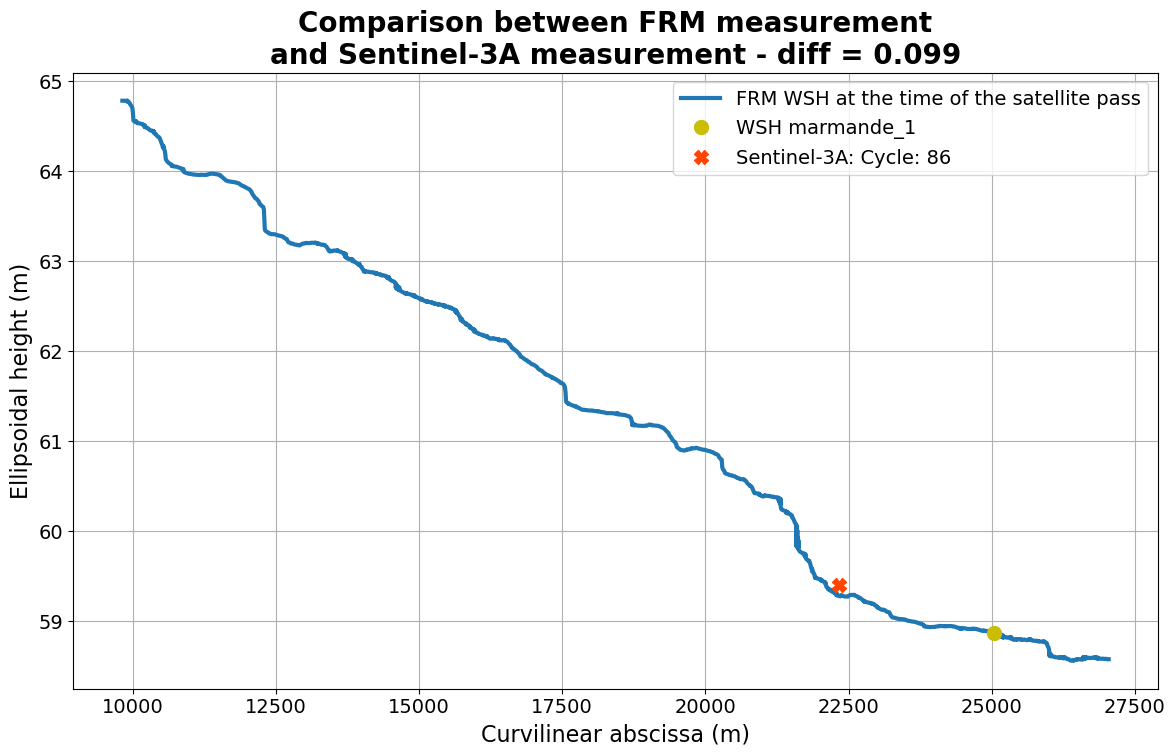

In [ ]:
# final FRM computation
wsh_frm = wsh_vtx_frm + slope_corr
frm_diff = d_s3a_meas['wsh_wgs84'] - wsh_frm

# Print Results
print("")
print("============================================")
print("Sentinel-3A Cycle: %d " % cycle)
print("Sentinel-3A R.O.N.: %d " % ron)
print("Sentinel-3A ellipsoidal WSH: %f m" % d_s3a_meas['wsh_wgs84'])
print("FRM ellipsoidal WSH: %f m" % wsh_frm)
print("Diff (S3A - FRM): %f m" % frm_diff)
print("============================================")


# Visualize
fig, ax = plt.subplots(figsize=(14,8))
plt.plot(df_drone_1_sorted['absc_curv'], wsh_vtx_frm + df_drone_1_sorted['h_diff'], lw=3, label='FRM WSH at the time of the satellite pass')
plt.plot(vtx_marmande_absc, wsh_vtx_frm, 'o', markersize=10, color='#CBBD06', label='WSH marmande_1')
plt.plot(s3a_absc_curv[0], d_s3a_meas['wsh_wgs84'], 'X', markersize=10, color='orangered', label='Sentinel-3A: Cycle: '+str(cycle))
plt.grid()
plt.legend(loc='best', fontsize=14)
plt.tick_params(labelsize=14)
plt.xlabel('Curvilinear abscissa (m)', fontsize=16)
plt.ylabel('Ellipsoidal height (m)', fontsize=16)
plt.title("Comparison between FRM measurement\nand Sentinel-3A measurement - diff = %.3f" % frm_diff, fontsize=20, fontweight='bold')